In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

Loaded data: 5964 days from 2008-11-20 to 2025-06-06
Training period: 2008-11-20 to 2020-12-31
Testing period: 2021-01-01 to 2025-06-06
Training samples: 4357, Testing samples: 1607

BASELINE MODEL COMPARISON

CLIMATOLOGY BASELINE

SEASONAL NAÏVE BASELINE

PERSISTENCE BASELINE

Evaluating Climatology...

Evaluating Seasonal Naïve...

Evaluating Persistence...

Performance Summary (MAE in °C):
--------------------------------------------------
Horizon  Climatology  Seasonal     Persistence 
--------------------------------------------------
1        4.39         5.98         3.17        
2        4.39         6.00         4.45        
3        4.38         6.00         5.00        
4        4.38         5.98         5.29        
5        4.37         5.98         5.45        
6        4.37         5.99         5.68        
7        4.37         6.00         5.86        
8        4.37         5.99         5.92        
9        4.37         5.99         5.99        
10       4.38         

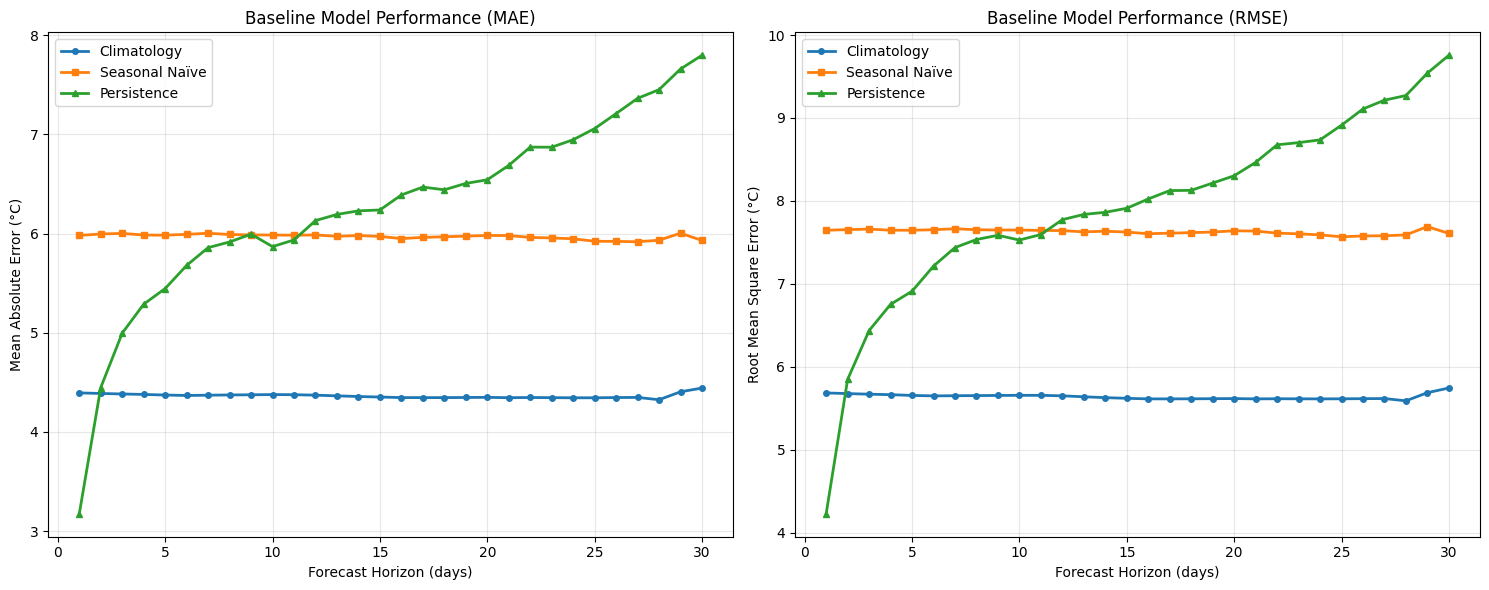

Saved baseline comparison plot as: baseline_comparison.png

Saved baseline comparison to: baseline_results.csv


In [3]:
class TemperatureBaselines:
    """Baseline models for temperature forecasting"""
    
    def __init__(self, data_path="temagami_features.csv"):
        """Load the feature-engineered data"""
        self.df = pd.read_csv(data_path, index_col=0, parse_dates=True)
        print(f"Loaded data: {len(self.df)} days from {self.df.index.min().date()} to {self.df.index.max().date()}")
        
    def setup_cross_validation(self, test_years=5):
        """Set up time series cross-validation with expanding windows"""
        # Use last few years for testing, rest for training
        self.test_start_year = self.df.index.max().year - test_years + 1
        self.train_data = self.df[self.df.index.year < self.test_start_year].copy()
        self.test_data = self.df[self.df.index.year >= self.test_start_year].copy()
        
        print(f"Training period: {self.train_data.index.min().date()} to {self.train_data.index.max().date()}")
        print(f"Testing period: {self.test_data.index.min().date()} to {self.test_data.index.max().date()}")
        print(f"Training samples: {len(self.train_data)}, Testing samples: {len(self.test_data)}")
        
        return self.train_data, self.test_data
    
    def climatology_baseline(self, horizon_days=90):
        """Climatology baseline: average temperature for each calendar day"""
        print("\n" + "="*50)
        print("CLIMATOLOGY BASELINE")
        print("="*50)
        
        # Calculate climatological averages by day-of-year
        self.train_data['dayofyear'] = self.train_data.index.dayofyear
        climatology = self.train_data.groupby('dayofyear')['t_mean'].mean()
        
        # Handle leap year edge case (Feb 29)
        if 366 not in climatology.index:
            # Use Feb 28 average for Feb 29
            climatology[366] = climatology[59]  # Feb 28 is day 59
        
        results = []
        
        # Generate forecasts for each day in test period
        for test_date in self.test_data.index:
            forecasts = []
            actual_temps = []
            forecast_dates = []
            
            for day_ahead in range(1, horizon_days + 1):
                forecast_date = test_date + timedelta(days=day_ahead)
                
                # Skip if forecast date is beyond our data
                if forecast_date not in self.test_data.index:
                    continue
                
                forecast_doy = forecast_date.dayofyear
                forecast_temp = climatology[forecast_doy]
                actual_temp = self.test_data.loc[forecast_date, 't_mean']
                
                forecasts.append(forecast_temp)
                actual_temps.append(actual_temp)
                forecast_dates.append(forecast_date)
            
            if forecasts:  # Only add if we have valid forecasts
                results.append({
                    'forecast_date': test_date,
                    'forecasts': forecasts,
                    'actuals': actual_temps,
                    'dates': forecast_dates,
                    'horizon_days': len(forecasts)
                })
        
        self.climatology_results = results
        return results
    
    def seasonal_naive_baseline(self, horizon_days=90):
        """Seasonal naïve: use temperature from exactly one year ago"""
        print("\n" + "="*50)
        print("SEASONAL NAÏVE BASELINE")
        print("="*50)
        
        results = []
        
        for test_date in self.test_data.index:
            forecasts = []
            actual_temps = []
            forecast_dates = []
            
            for day_ahead in range(1, horizon_days + 1):
                forecast_date = test_date + timedelta(days=day_ahead)
                
                # Skip if forecast date is beyond our data
                if forecast_date not in self.test_data.index:
                    continue
                
                # Look for temperature exactly one year ago
                year_ago_date = forecast_date - timedelta(days=365)
                
                # Try to find historical temperature (with some flexibility for leap years)
                forecast_temp = None
                for offset in [0, -1, 1]:  # Check exact date, then ±1 day
                    check_date = year_ago_date + timedelta(days=offset)
                    if check_date in self.df.index:
                        forecast_temp = self.df.loc[check_date, 't_mean']
                        break
                
                if forecast_temp is not None:
                    actual_temp = self.test_data.loc[forecast_date, 't_mean']
                    forecasts.append(forecast_temp)
                    actual_temps.append(actual_temp)
                    forecast_dates.append(forecast_date)
            
            if forecasts:
                results.append({
                    'forecast_date': test_date,
                    'forecasts': forecasts,
                    'actuals': actual_temps,
                    'dates': forecast_dates,
                    'horizon_days': len(forecasts)
                })
        
        self.seasonal_naive_results = results
        return results
    
    def persistence_baseline(self, horizon_days=90):
        """Persistence baseline: use the last observed temperature"""
        print("\n" + "="*50)
        print("PERSISTENCE BASELINE")
        print("="*50)
        
        results = []
        
        for test_date in self.test_data.index:
            # Use temperature from the forecast date as persistence
            if test_date not in self.test_data.index:
                continue
                
            last_temp = self.test_data.loc[test_date, 't_mean']
            
            forecasts = []
            actual_temps = []
            forecast_dates = []
            
            for day_ahead in range(1, horizon_days + 1):
                forecast_date = test_date + timedelta(days=day_ahead)
                
                if forecast_date not in self.test_data.index:
                    continue
                
                actual_temp = self.test_data.loc[forecast_date, 't_mean']
                forecasts.append(last_temp)  # Persist the same temperature
                actual_temps.append(actual_temp)
                forecast_dates.append(forecast_date)
            
            if forecasts:
                results.append({
                    'forecast_date': test_date,
                    'forecasts': forecasts,
                    'actuals': actual_temps,
                    'dates': forecast_dates,
                    'horizon_days': len(forecasts)
                })
        
        self.persistence_results = results
        return results
    
    def evaluate_baseline(self, results, model_name):
        """Evaluate baseline model performance by forecast horizon"""
        print(f"\nEvaluating {model_name}...")
        
        # Collect all forecasts by horizon
        horizon_performance = {}
        
        for result in results:
            for i, (forecast, actual) in enumerate(zip(result['forecasts'], result['actuals'])):
                horizon = i + 1
                if horizon not in horizon_performance:
                    horizon_performance[horizon] = {'forecasts': [], 'actuals': []}
                
                horizon_performance[horizon]['forecasts'].append(forecast)
                horizon_performance[horizon]['actuals'].append(actual)
        
        # Calculate metrics by horizon
        horizon_metrics = {}
        for horizon in sorted(horizon_performance.keys()):
            forecasts = np.array(horizon_performance[horizon]['forecasts'])
            actuals = np.array(horizon_performance[horizon]['actuals'])
            
            mae = mean_absolute_error(actuals, forecasts)
            rmse = np.sqrt(mean_squared_error(actuals, forecasts))
            
            horizon_metrics[horizon] = {
                'mae': mae,
                'rmse': rmse,
                'n_forecasts': len(forecasts)
            }
        
        return horizon_metrics
    
    def compare_baselines(self, max_horizon=30):
        """Compare all baseline models"""
        print("\n" + "="*60)
        print("BASELINE MODEL COMPARISON")
        print("="*60)
        
        # Run all baselines
        climatology_results = self.climatology_baseline(max_horizon)
        seasonal_naive_results = self.seasonal_naive_baseline(max_horizon)
        persistence_results = self.persistence_baseline(max_horizon)
        
        # Evaluate each
        clim_metrics = self.evaluate_baseline(climatology_results, "Climatology")
        seasonal_metrics = self.evaluate_baseline(seasonal_naive_results, "Seasonal Naïve")
        persist_metrics = self.evaluate_baseline(persistence_results, "Persistence")
        
        # Create comparison dataframe
        comparison_data = []
        horizons = sorted(set(clim_metrics.keys()) & set(seasonal_metrics.keys()) & set(persist_metrics.keys()))
        
        for horizon in horizons[:max_horizon]:
            comparison_data.append({
                'Horizon': horizon,
                'Climatology_MAE': clim_metrics[horizon]['mae'],
                'Seasonal_Naive_MAE': seasonal_metrics[horizon]['mae'],
                'Persistence_MAE': persist_metrics[horizon]['mae'],
                'Climatology_RMSE': clim_metrics[horizon]['rmse'],
                'Seasonal_Naive_RMSE': seasonal_metrics[horizon]['rmse'],
                'Persistence_RMSE': persist_metrics[horizon]['rmse']
            })
        
        self.comparison_df = pd.DataFrame(comparison_data)
        
        # Print summary
        print(f"\nPerformance Summary (MAE in °C):")
        print("-" * 50)
        print(f"{'Horizon':<8} {'Climatology':<12} {'Seasonal':<12} {'Persistence':<12}")
        print("-" * 50)
        
        for _, row in self.comparison_df.head(10).iterrows():
            print(f"{int(row['Horizon']):<8} {row['Climatology_MAE']:<12.2f} {row['Seasonal_Naive_MAE']:<12.2f} {row['Persistence_MAE']:<12.2f}")
        
        return self.comparison_df
    
    def plot_baseline_comparison(self):
        """Plot baseline model performance"""
        if not hasattr(self, 'comparison_df'):
            print("Run compare_baselines() first")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # MAE comparison
        ax1.plot(self.comparison_df['Horizon'], self.comparison_df['Climatology_MAE'], 
                'o-', label='Climatology', linewidth=2, markersize=4)
        ax1.plot(self.comparison_df['Horizon'], self.comparison_df['Seasonal_Naive_MAE'], 
                's-', label='Seasonal Naïve', linewidth=2, markersize=4)
        ax1.plot(self.comparison_df['Horizon'], self.comparison_df['Persistence_MAE'], 
                '^-', label='Persistence', linewidth=2, markersize=4)
        
        ax1.set_xlabel('Forecast Horizon (days)')
        ax1.set_ylabel('Mean Absolute Error (°C)')
        ax1.set_title('Baseline Model Performance (MAE)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # RMSE comparison
        ax2.plot(self.comparison_df['Horizon'], self.comparison_df['Climatology_RMSE'], 
                'o-', label='Climatology', linewidth=2, markersize=4)
        ax2.plot(self.comparison_df['Horizon'], self.comparison_df['Seasonal_Naive_RMSE'], 
                's-', label='Seasonal Naïve', linewidth=2, markersize=4)
        ax2.plot(self.comparison_df['Horizon'], self.comparison_df['Persistence_RMSE'], 
                '^-', label='Persistence', linewidth=2, markersize=4)
        
        ax2.set_xlabel('Forecast Horizon (days)')
        ax2.set_ylabel('Root Mean Square Error (°C)')
        ax2.set_title('Baseline Model Performance (RMSE)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('baseline_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("Saved baseline comparison plot as: baseline_comparison.png")

def main():
    """Run the baseline comparison"""
    # Initialize baselines
    baselines = TemperatureBaselines("temagami_features.csv")
    
    # Set up cross-validation
    train_data, test_data = baselines.setup_cross_validation(test_years=5)
    
    # Compare all baselines
    comparison_df = baselines.compare_baselines(max_horizon=30)
    
    # Plot results
    baselines.plot_baseline_comparison()
    
    # Save results
    comparison_df.to_csv("baseline_results.csv", index=False)
    print(f"\nSaved baseline comparison to: baseline_results.csv")
    
    return baselines, comparison_df

if __name__ == "__main__":
    baselines, results = main()